# Purpose
* Reproduce the example from [Harald Vöhringer's Config Enumerate in Pyro](https://haraldvohringer.com/blog/config-enumerate-in-pyro/)

## Pyro Example

In [1]:
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def sample(n=1):
    urn = pyro.distributions.Categorical(torch.ones(10)/10).sample()
    draws = pyro.distributions.Binomial(10, urn/10).sample((n,))
    return urn, draws

In [3]:
true_urn, draws = sample(10)
print(f"{true_urn=} | {draws=}")

true_urn=tensor(1) | draws=tensor([2., 0., 2., 4., 5., 0., 0., 1., 1., 0.])


In [4]:
@pyro.infer.config_enumerate
def model(y):
    u = pyro.sample('u', pyro.distributions.Dirichlet(torch.ones(10)))
    with pyro.plate('data', y.shape[0]):
        urn = pyro.sample('urn', pyro.distributions.Categorical(u))
        pyro.sample('obs', pyro.distributions.Binomial(10, urn/10), obs=y)
        
guide = pyro.infer.autoguide.AutoDiagonalNormal(pyro.poutine.block(model, expose=["u"]))

In [5]:
loss = pyro.infer.TraceEnum_ELBO(max_plate_nesting=1)

In [6]:
pyro.clear_param_store()
adam = pyro.optim.Adam({'lr': .001})
svi = pyro.infer.SVI(model, guide, adam, loss)
num_steps= 10000
losses = []
for _ in tqdm(range(num_steps)):
    loss = svi.step(draws)
    losses.append(loss)

100%|██████████| 10000/10000 [01:14<00:00, 133.38it/s]


[Text(0, 0.5, 'ELBO'), Text(0.5, 0, 'Step')]

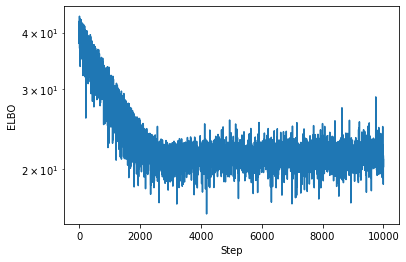

In [7]:
plt.semilogy(losses)
ax = plt.gca()
ax.set(
    ylabel='ELBO',
    xlabel='Step'
)

In [8]:
posterior = pyro.infer.Predictive(model, guide=guide, num_samples=5000)
params = posterior(draws)
posterior_u = params['u'].detach().numpy()

In [9]:
print(f"{true_urn=} | {draws=}")

true_urn=tensor(1) | draws=tensor([2., 0., 2., 4., 5., 0., 0., 1., 1., 0.])


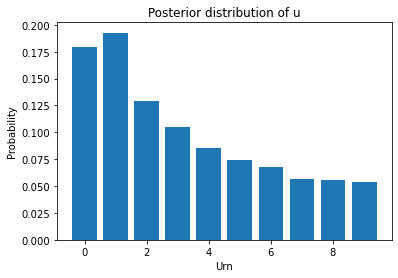

In [10]:
plt.bar(np.arange(10), posterior_u.mean(0).reshape(-1))
_ = plt.gca().set(
    xlabel='Urn',
    ylabel='Probability',
    title='Posterior distribution of u'
)

## NumPyro Example

In [11]:
import jax
import jax.numpy as jnp
import pandas as pd
import arviz as az

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

In [12]:
key = jax.random.PRNGKey(0)
key, key_split = jax.random.split(key)
key_split, key_split_split = jax.random.split(key_split)

In [13]:
def sample(n, key):
    urn = dist.Categorical(jnp.ones(10)/10).sample(key)
    draws = dist.Binomial(10, urn/10).sample(key, (n,))
    return urn, draws

In [14]:
true_urn, draws = sample(10, key_split_split)
print(f"{true_urn=} | {draws=}")

true_urn=DeviceArray(8, dtype=int32) | draws=DeviceArray([ 7,  5,  9,  8,  7,  7,  8,  8, 10,  7], dtype=int32)


In [15]:
def model(y):
    u = numpyro.sample('u', dist.Dirichlet(jnp.ones(10)))
    with numpyro.plate('data', y.shape[0]):
        urn = numpyro.sample('urn', dist.Categorical(u))
        numpyro.sample('obs', dist.Binomial(10, urn/10), obs=y)

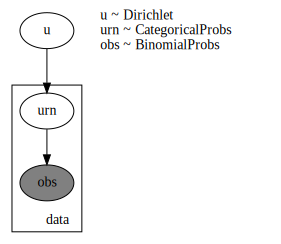

In [16]:
numpyro.render_model(model, (draws,), render_distributions=True)

In [17]:
nuts_kernel = NUTS(model)
num_chains, num_samples = 4, 1000
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=num_samples, num_chains=num_chains)
mcmc.run(key, draws, extra_fields=("potential_energy",))

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:00<00:00, 4902.67it/s, 15 steps of size 4.43e-01. acc. prob=0.90]


In [18]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      u[0]      0.05      0.05      0.04      0.00      0.11   5552.34      1.00
      u[1]      0.05      0.05      0.04      0.00      0.11   6540.95      1.00
      u[2]      0.05      0.05      0.04      0.00      0.12   6256.88      1.00
      u[3]      0.05      0.05      0.04      0.00      0.12   5007.21      1.00
      u[4]      0.06      0.06      0.04      0.00      0.14   4587.33      1.00
      u[5]      0.08      0.07      0.06      0.00      0.18   5348.43      1.00
      u[6]      0.12      0.10      0.09      0.00      0.26   5715.00      1.00
      u[7]      0.18      0.14      0.15      0.00      0.39   5395.95      1.00
      u[8]      0.22      0.15      0.19      0.00      0.43   4339.78      1.00
      u[9]      0.13      0.10      0.11      0.00      0.28   5767.79      1.00

Number of divergences: 0


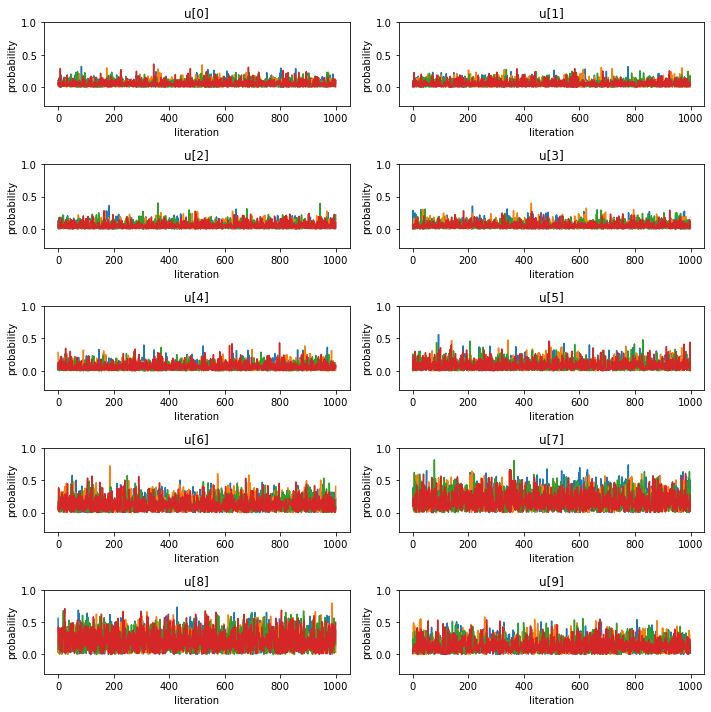

In [19]:
fig, axes = plt.subplots(5, 2, figsize=(10,10))

for i, ax in enumerate(axes.flatten()):
    for row in mcmc.get_samples()["u"][:,i].reshape((num_chains,num_samples)):
        ax.set_ylim((-0.3, 1.))
        ax.set_ylabel("probability")
        ax.set_xlabel("Iiteration")
        ax.plot(row)
        ax.set_title(f"u[{i}]")

fig.tight_layout()
plt.show()

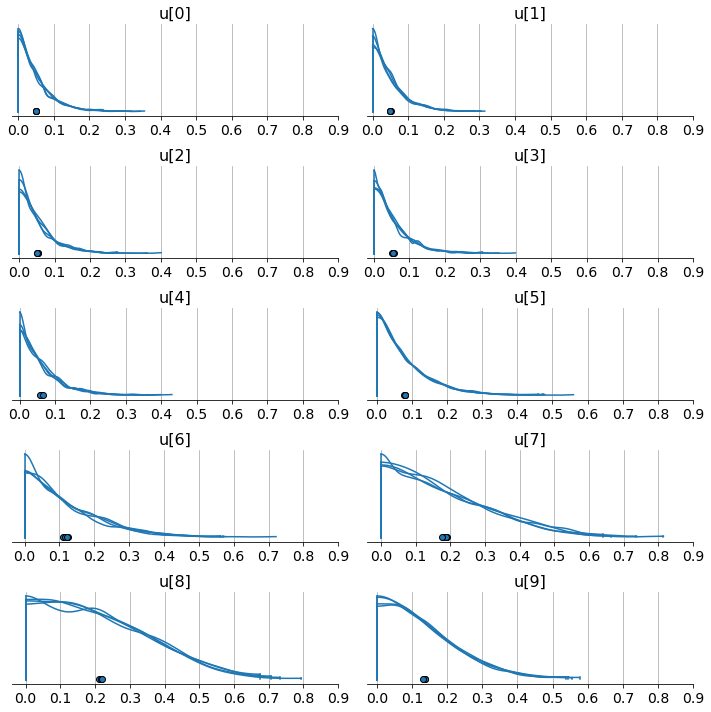

In [20]:
fig, axes = plt.subplots(5, 2, figsize=(10,10))

for i, ax in enumerate(axes.flatten()):
    for row in mcmc.get_samples()["u"][:,i].reshape((num_chains,num_samples)):
        az.plot_density({"u[{}]".format(i): row}, hdi_prob=1,ax=ax)
        ax.set_xticks(np.arange(0, 1, 0.1))
        ax.grid(True)

fig.tight_layout()
plt.show()

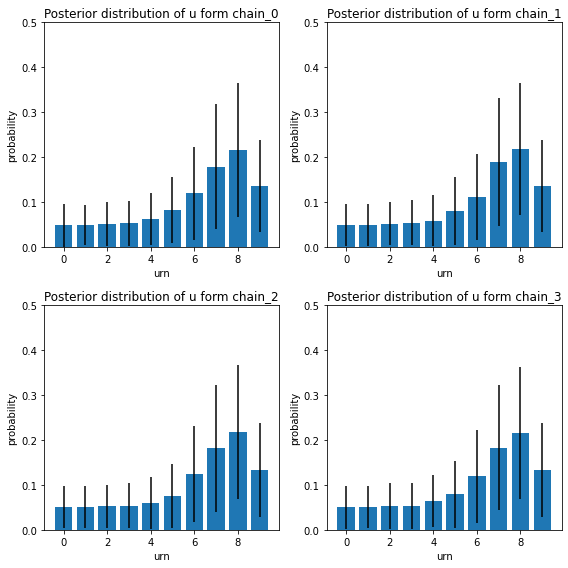

In [21]:
# https://stackoverflow.com/a/39622821/3587374
trace_mean = mcmc.get_samples()["u"].reshape(mcmc.get_samples()["u"].shape[0] // num_chains, -1, mcmc.get_samples()["u"].shape[1]).mean(axis=0)
trace_std = mcmc.get_samples()["u"].reshape(mcmc.get_samples()["u"].shape[0] // num_chains, -1, mcmc.get_samples()["u"].shape[1]).std(axis=0)

fig, axes = plt.subplots(2, 2, figsize=(8,8))

for i, ax in enumerate(axes.flatten()):
    ax.bar(np.arange(10), trace_mean[i].reshape(-1), yerr=trace_std[i].reshape(-1))
    ax.set_ylim((0, 0.5))
    ax.set_ylabel("probability")
    ax.set_xlabel("urn")
    ax.set_title(f"Posterior distribution of u form chain_{i}")

fig.tight_layout()
plt.show()

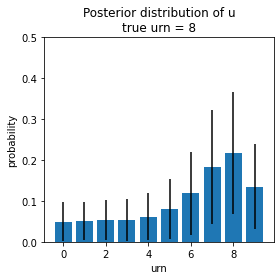

In [22]:
fig, ax = plt.subplots(figsize=(4,4))
ax.bar(np.arange(10), mcmc.get_samples()["u"].mean(axis=0).reshape(-1), yerr=mcmc.get_samples()["u"].std(axis=0).reshape(-1))
ax.set_ylim((0, 0.5))
ax.set_ylabel("probability")
ax.set_xlabel("urn")
ax.set_title(f"Posterior distribution of u\ntrue urn = {true_urn.item()}")
fig.tight_layout()
plt.show()